In [540]:
import sys
from tax_tree import *
import matplotlib.pyplot as plt
from os.path import exists
import pickle
import scipy.stats as st
from math import ceil
from unifrac_distance import unifrac_from_profiles

def get_labels_from_query(annot):
    if len(annot) == 0:
        return 0, annot

    # <NC_022968.1>:330:111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111:360

    pathlen = len(annot[0].split(":")[-2])
    labels = [[[], 1] for i in range(pathlen)]
    for match_info in annot:
        match, dummy, sig, dummy = match_info.split(":")
        match = match[1:-1].split(".")[0]
        for i,v in enumerate(sig):
            if v == "1":
                labels[i][0].append(match)
    for m in labels:
        if len(m[0]) == 0:
            m[0].append("")

    cur,count = labels[0]
    outlabels = []
    for nxt,c in labels[1:]:
        if len(cur) == len(nxt) and all(a==b for a,b in zip(cur,nxt)):
            count += 1
        else:
            outlabels.append([cur,count])
            cur,count = nxt,c
    outlabels.append([cur,count])
    assert(sum(c for a,c in outlabels) == pathlen)

    return pathlen, outlabels

def get_labels_from_align(path, reflen, offset, k = 31):
    pathlen = reflen - k + 1 + offset
    if len(path) == 0:
        return pathlen, path

    path = path.split(">")
    if len(path) == 1:
        if path[0][:4] == "refs":
            path[0] = f'{";".join([p.split("/")[1].split(":")[0] for p in path[0].split(";")])}:{pathlen}'                
        elif path[0].find(":") == -1:
            path[0] = f'{path[0]}:{pathlen}'

    path = [[[b.split(".")[0] for b in a.split(";")],int(b)] for p in path for a,b in [p.split(":")]]
    assert(sum(b for a,b in path) == pathlen)
    return pathlen, path

read_file_template="test_reads{}.shuf.fa.head2000.fa"
files = [
    ("tcg.out", "Reference"),
    ("ga.gaf.results.out", "GraphAligner"),
    ("gmg.gaf.results.out", "minigraph"),
    ("mtgfullnochain.out", "MetaGraph-Align"),
    ("mtgnochain.out", "MetaGraph-LA"),
    ("mtg.out", "MetaGraph-MLA"),
]
read_types = [
    ("", "Illumina"),
    (".pacbio", "PacBio CLR"),
    (".hifi", "PacBio CCS"),
]

In [ ]:
lengths = []
fnames = []
uniss = []
comp_uniss = []
k = 31
for read_type, read_type_label in read_types:
    read_file = read_file_template.format(read_type)
    for fn, file_label in files:
        file_name = f'{read_file}.{fn}'
        fnames.append(file_label)
        print(file_name)
        local_lengths = []
        local_uniss = []
        local_comp_uniss = []
        if exists(file_name + ".pkl"):
            with open(file_name + ".pkl", 'rb') as p:
                local_lengths, local_uniss, local_comp_uniss = pickle.load(p)
        else:
            with open(file_name, 'r') as f:
                align_fracs = []
                unis = []
                comp_unis = []
                if (fn[:3] == "mtg" and fn[:7] != "mtgfull") or (fn[:3] == "tcg"):
                    # aligner
                    for line in f:
                        line = line.rstrip().split("\t")
                        if len(line) < 9:
                            read_name, inseq, orientation, match, score, nmates, cigar, offset = line[:8]
                            seqname = read_name.split("|")[3].split(".")[0]
                            seqtaxid = acc2taxid[seqname]
                            best_rank = max_dist_to_root
                            hmr = max_dist_to_root
                            align_fracs.append(0.0)
                            pred_str = cami_profile_from_labels(0, [[[''], 0]])
                            true_str = cami_profile_from_labels(1,[[[seqname], 1]])
                            wuf,uuf = unifrac_from_profiles(true_str, pred_str)[0]
                            unis.append(wuf)
                            comp_unis.append([]) # not used
                            continue
                        else:
                            read_name, inseq, orientation, match, score, nmates, cigar, offset, annot = line[:9]
                        seqname = read_name.split("|")[3].split(".")[0]
                        clipping, inseqlen, reflen, num_disconnects = get_clipping(cigar)
                        assert(inseqlen == len(inseq))
                        pathlen,labels = get_labels_from_align(annot, reflen, int(offset))
                        seqtaxid, mrr, lca_mrrs = get_report(seqname, labels)
                        pred_str = cami_profile_from_labels(pathlen,labels)
                        true_str = cami_profile_from_labels(inseqlen-k+1,[[[seqname], inseqlen-k+1]])
                        wuf,uuf = unifrac_from_profiles(true_str, pred_str)[0]
                        assert(pred_str != true_str or wuf == 0.0)
                        align_fracs.append((inseqlen - clipping)/inseqlen)
                        unis.append(wuf)
                        c_uni = []
                        for label in labels:
                            if len(label[0]) > 0:
                                pred_str = cami_profile_from_labels(label[1],[label])
                                true_str = cami_profile_from_labels(1,[[[seqname], 1]])
                                wuf,uuf = unifrac_from_profiles(true_str, pred_str)[0]
                                c_uni.append([label[1],wuf])
                        c_uni = sorted(c_uni,reverse=True)
                        comp_unis.append(np.array([b for a,b in c_uni]))
                else:
                    last_mrr = False
                    last_read_name = ""
                    # query
                    for line in f:
                        line = line.rstrip().split("\t")
                        num, read_info = line[:2]
                        read_name, refseq, score, cigar = read_info.split(":")
                        annot = line[2:]
                        seqname = read_name.split("|")[3].split(".")[0]
                        clipping, inseqlen, reflen, num_disconnects = get_clipping(cigar)
                        pathlen,labels = get_labels_from_query(annot)
                        seqtaxid, mrr, lca_mrrs = get_report(seqname, labels)
                        pred_str = cami_profile_from_labels(pathlen,labels)
                        true_str = cami_profile_from_labels(inseqlen-k+1,[[[seqname], inseqlen-k+1]])
                        wuf,uuf = unifrac_from_profiles(true_str, pred_str)[0]
                        assert(pred_str != true_str or wuf == 0.0)
                        if read_name != last_read_name:
                            align_fracs.append((inseqlen - clipping)/inseqlen)
                            unis.append(wuf)
                            last_mrr = mrr[0]
                            comp_unis.append([]) # not used
                        elif last_mrr < mrr[0]:
                            align_fracs[-1] = (inseqlen - clipping)/inseqlen
                            unis[-1] = wuf
                            last_mrr = mrr[0]
                        last_read_name = read_name
                assert(len(align_fracs) == len(unis))
                assert(len(align_fracs) == len(comp_unis))
                local_lengths.append(np.array(align_fracs))
                local_uniss.append(np.array(unis))
                local_comp_uniss.append(comp_unis)
            with open(file_name + ".pkl", 'wb') as p:
                pickle.dump((local_lengths, local_uniss, local_comp_uniss), p)
        assert(len(local_lengths[-1]) == 1000)
        lengths += local_lengths
        uniss += local_uniss
        comp_uniss += local_comp_uniss
lengths = np.vstack(lengths)
unis = np.vstack(uniss)
print("done")

test_reads.shuf.fa.head2000.fa.tcg.out
test_reads.shuf.fa.head2000.fa.ga.gaf.results.out
test_reads.shuf.fa.head2000.fa.gmg.gaf.results.out
test_reads.shuf.fa.head2000.fa.mtgfullnochain.out
test_reads.shuf.fa.head2000.fa.mtgnochain.out
test_reads.shuf.fa.head2000.fa.mtg.out
test_reads.pacbio.shuf.fa.head2000.fa.tcg.out
test_reads.pacbio.shuf.fa.head2000.fa.ga.gaf.results.out


In [548]:
plt.rcParams['font.size'] = 24

for i,(fn,ln,un) in enumerate(zip(fnames,lengths, unis)):
    if i and fn[:3] == "Ref":
        print()
    lnmean = ln.mean()*100
    lnmedian = np.median(np.array(ln)*100)
    
    unmean = un.mean()
    unmedian = np.median(np.array(un))
    unhmean = st.hmean(np.array(un)+1)-1
    
    print('&{:>20}&\t{:.1f}&{:.1f}&\t{:.2f}&{:.2f}&{:.2f}'.format(
        fn,
        lnmean,lnmedian,
        unmean,unmedian,unhmean,
    ))

&           Reference&	97.1&100.0&	0.77&0.00&0.22
&        GraphAligner&	73.2&100.0&	2.23&0.00&0.58
&           minigraph&	17.6&0.0&	5.76&7.00&2.58
&     MetaGraph-Align&	75.3&100.0&	2.04&0.00&0.53
&        MetaGraph-LA&	74.3&100.0&	2.08&0.00&0.54
&       MetaGraph-MLA&	81.8&100.0&	2.17&0.48&0.60

&           Reference&	92.7&100.0&	0.79&0.00&0.16
&        GraphAligner&	45.5&24.9&	2.84&1.02&0.76
&           minigraph&	1.3&0.0&	6.76&7.00&4.85
&     MetaGraph-Align&	52.7&44.6&	1.60&0.00&0.45
&        MetaGraph-LA&	19.0&16.8&	1.52&0.00&0.36
&       MetaGraph-MLA&	58.9&61.4&	1.51&0.34&0.56

&           Reference&	94.7&100.0&	0.74&0.00&0.17
&        GraphAligner&	68.9&96.9&	1.73&0.00&0.44
&           minigraph&	18.9&0.0&	4.73&7.00&1.67
&     MetaGraph-Align&	71.6&99.7&	1.54&0.00&0.39
&        MetaGraph-LA&	61.1&66.1&	1.56&0.00&0.38
&       MetaGraph-MLA&	78.3&100.0&	1.79&0.38&0.61


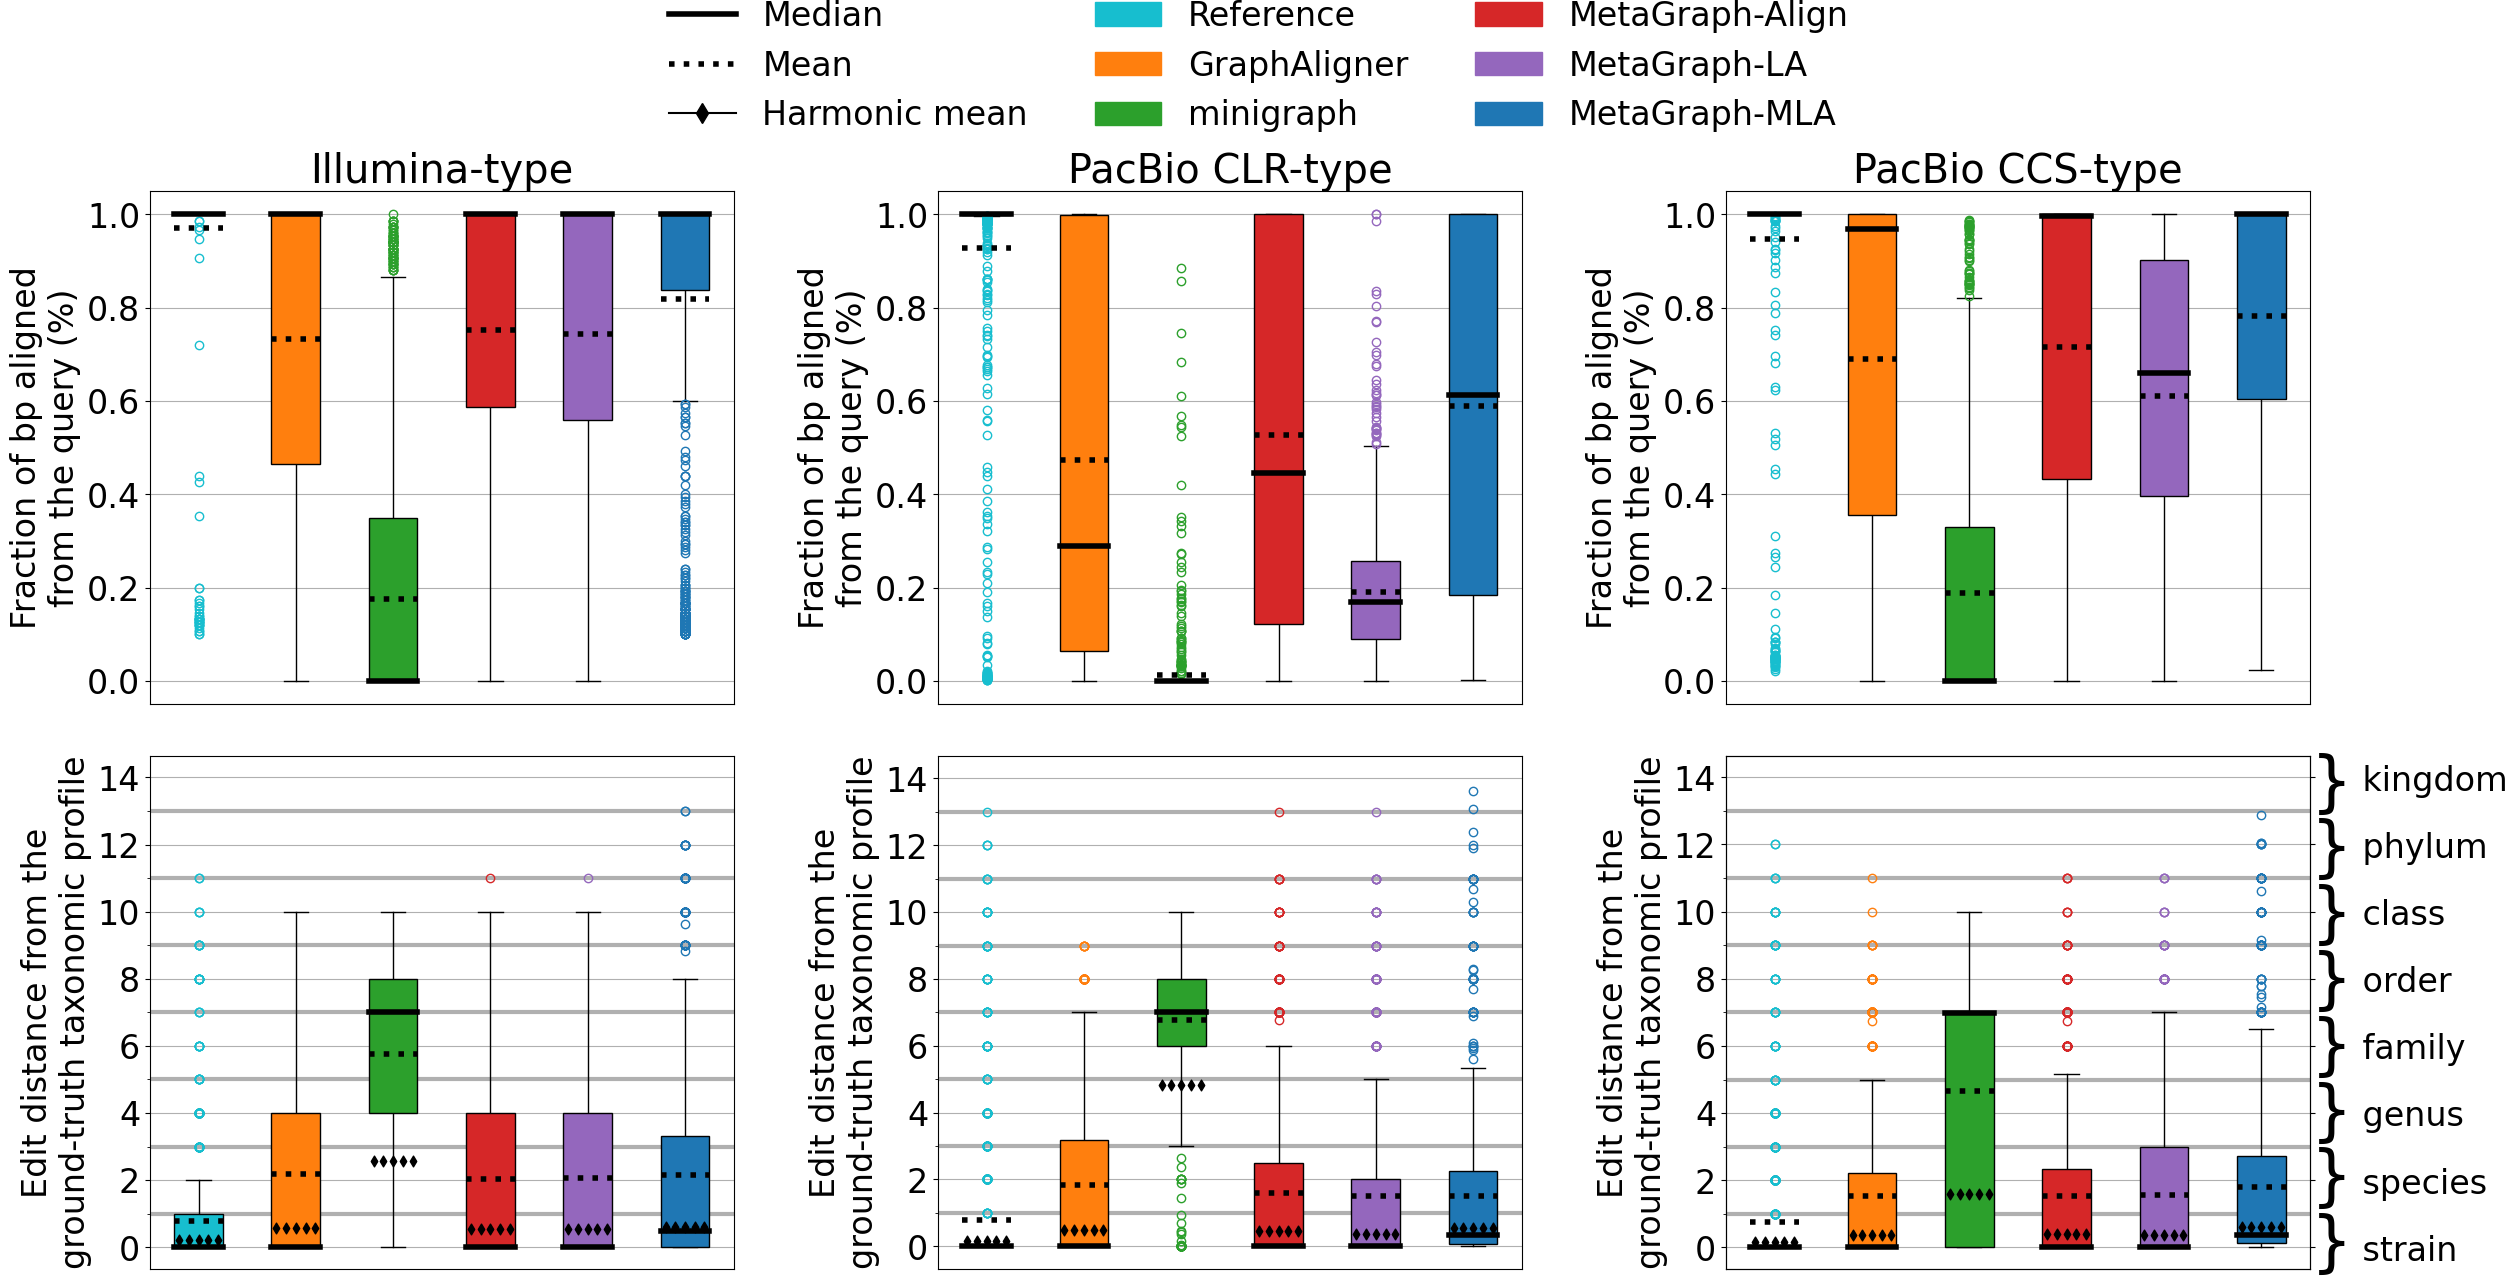

In [545]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

fig, axss = plt.subplots(ncols=len(read_types),nrows=2,figsize=(8*len(read_types),14),sharex=True)
batch_size = int(len(lengths)/len(read_types))
boxalpha=1
for (i,(read_type, read_type_label)),axs in zip(enumerate(read_types),axss.T):
    ax,ax3 = axs
    lbatch = lengths[i*batch_size:(i+1)*batch_size]
    ubatch = unis[i*batch_size:(i+1)*batch_size]
    
    colors = [f'C{j+1 if j + 1 == len(files) else j}' for j in np.arange(len(files))]
    colors[0],colors[-1] = colors[-1],colors[0]
    colors[0] = f'C{len(files)+3}'
    labels=[file_label for fn,file_label in files]
    
    boxes1 = ax.boxplot(x=[np.array(a) for (fn,file_label),a in zip(files, lbatch)],
               patch_artist=True,
               medianprops={'color':'black','linewidth':4},
               meanprops={'color':'black','linewidth':4,'linestyle':':'},
               meanline=True, showmeans=True)
    ax.set_xticks([])
    for c,b in zip(colors,boxes1['boxes']):
        b.set_facecolor(c)
        b.set_alpha(boxalpha)
    for c,b in zip(colors,boxes1['fliers']):
        b.set_markeredgecolor(c)
        
    boxes2 = ax3.boxplot(x=[np.array(a) for (fn,file_label),a in zip(files, ubatch)],
               patch_artist=True,
               medianprops={'color':'black','linewidth':4},
               meanprops={'color':'black','linewidth':4,'linestyle':':'},meanline=True, showmeans=True)    
    
    ax3.set_xticks([])
    for c,b in zip(colors,boxes2['boxes']):
        b.set_facecolor(c)
        b.set_alpha(boxalpha)
        b.set_zorder(2)
    for c,b in zip(colors,boxes2['fliers']):
        b.set_markeredgecolor(c)
    
    ax3.set_ylim([ax3.get_ylim()[0], 14 - ax3.get_ylim()[0]])
    yticks = np.array([0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0])
    ax3.set_yticks(yticks)
    ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
    if i + 1 == len(read_types):
        secax = ax3.twinx()
        secax.set_ylim(ax3.get_ylim())
        secax.set_yticks(yticks)
        secax.set_yticklabels([f'    {l}' for l in rank_titles[1:len(label_yticks)+1]])
        for pp in np.arange(len(yticks))-1:
            secax.annotate(r"$\}$",fontsize=47,fontweight="ultralight",
                    xy=(1, (pp*2)/15.6+0.14), xycoords='axes fraction')


    ax.grid(which="both")
    ax3.grid(which="major")
    ax3.grid(which="minor",linewidth=3)
    ax.set_ylabel("Fraction of bp aligned\nfrom the query (%)")
    ax3.set_ylabel("Edit distance from the\nground-truth taxonomic profile")
    ax.set_title(f'{read_type_label}-type')
    
    #harmonic means
    u_hmeans = [st.hmean(np.array(a)+1)-1 for a in ubatch]
    for d in np.arange(-0.2,0.3,0.1):
        ax3.scatter(np.arange(len(ubatch))+1+d,u_hmeans,marker="d",s=30,c='black',zorder=10)
        
plt.subplots_adjust(left=0,wspace=0.35, hspace=0.1)
barhandles = [mpatches.Patch(color=color, alpha=boxalpha, label=label) for color,label in zip(colors,labels)]
handles = [mlines.Line2D([0], [0], color='black', lw=4, label='Median'),
                   mlines.Line2D([0], [0], color='black', lw=4, label='Mean',linestyle=':'),
           mlines.Line2D([0], [0], marker='d', color='black', label='Harmonic mean', markerfacecolor='black',markersize=10),
          ] \
            + barhandles[:1] \
            + barhandles[1:4] \
             + barhandles[4:]
            
fig.legend(handles=handles, ncol=3,loc='upper center', borderaxespad=-0.4).get_frame().set_linewidth(0)
fig.savefig('plot.query.pdf',pad_inches=0,bbox_inches="tight")

# added regions to chain are taxonomically related

/home/hmustafa/miniconda3/envs/opal/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/hmustafa/miniconda3/envs/opal/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/home/hmustafa/miniconda3/envs/opal/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning

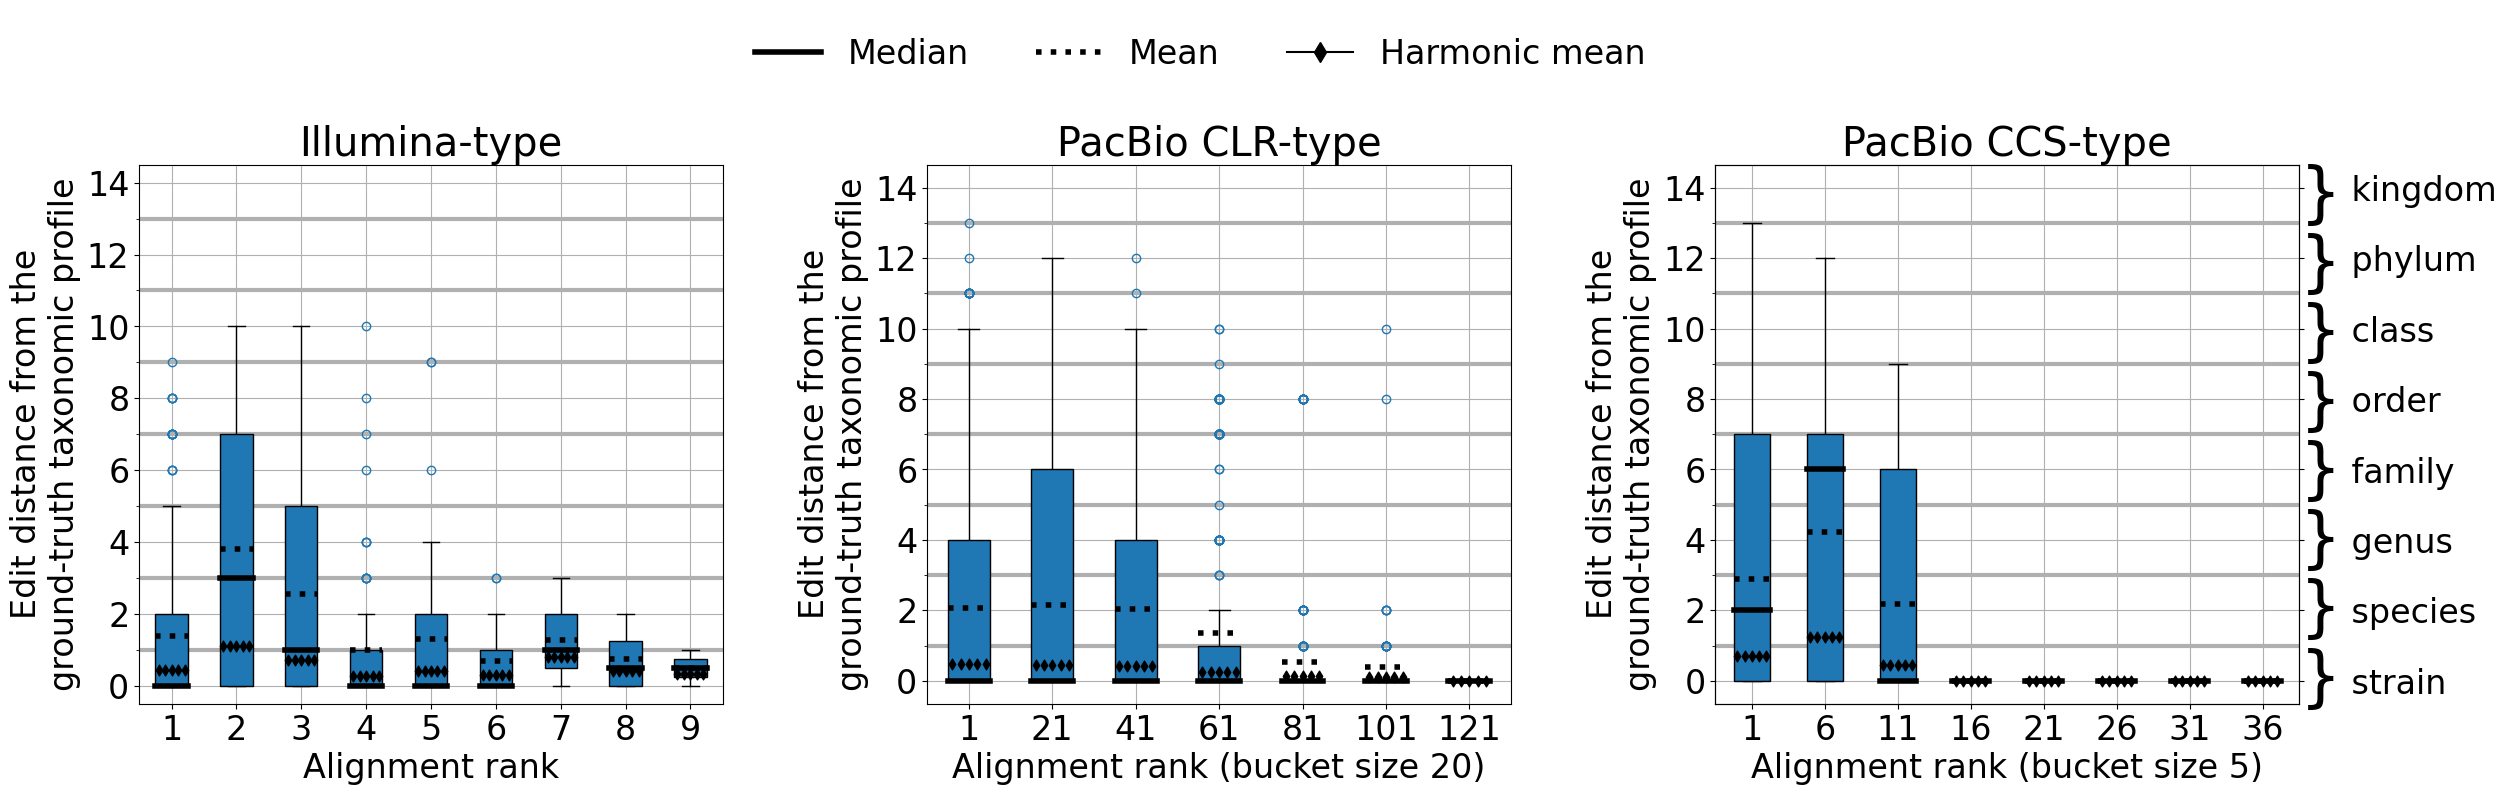

In [546]:
from matplotlib.ticker import MaxNLocator

batch_size = int(len(lengths)/len(read_types))
fig, axs = plt.subplots(ncols=len(read_types),nrows=1,figsize=(8*len(read_types),7))
len_cutoff = 0
for (i,(read_type, read_type_label)),ax in zip(enumerate(read_types), axs):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    cbatch = comp_uniss[i*batch_size:(i+1)*batch_size]
    assert(len(cbatch) == len(files))
    for j,((fn,file_label),cn) in enumerate(zip(files,cbatch)):
        if fn[:3] != "mtg" or fn[:7] == "mtgfull":
            assert(all(len(c) == 0) for c in cn)
            continue
        if fn != "mtg.out":
            continue
        assert(len(cn)==len(mb)) # sanity check
        maxlen = max([len(c) for c in cn])
        transposed = [[] for i in range(maxlen)]
        for c in cn:
            if len(c) > 1:
                for aln_rank,v in enumerate(c):
                    transposed[aln_rank].append(v)
        transposed = [a for a in transposed if len(a) >= len_cutoff]
        step=1
        if len(transposed) > 10:
            if len(transposed) < 40:
                step=5
            else:
                step=20
            transposed = [[b for a in transposed[i:i+step] for b in a] for i in range(0,len(transposed),step)]
        bplot = ax.boxplot(transposed,patch_artist=True,medianprops={'color':'black','linewidth':4},
                          meanprops={'color':'black','linewidth':4,'linestyle':':'},meanline=True, showmeans=True)
        for patch in bplot['boxes']:
            patch.set_alpha(boxalpha)
            patch.set_facecolor(colors[-1])
        for patch in bplot['fliers']:
            patch.set_markeredgecolor(colors[-1])
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_xticklabels([str((a-1)*step+1) for a in xticks])
        
        #harmonic means
        u_hmeans = [st.hmean(np.array(a)+1)-1 for a in transposed]
        for d in np.arange(-0.2,0.3,0.1):
            ax.scatter(np.arange(len(transposed))+1+d,u_hmeans,marker="d",s=30,c='black',zorder=10)
        
    yticks = np.array([0.0, 2.0,4.0,6.0,8.0,10.0,12.0,14.0])
    ax.set_ylim([ax.get_ylim()[0], 14 - ax.get_ylim()[0]])
    ax.set_yticks(yticks)
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if i + 1 == len(read_types):
        secax = ax.twinx()
        secax.set_ylim(ax.get_ylim())
        secax.set_yticks(yticks)
        secax.set_yticklabels([f'    {l}' for l in rank_titles[1:len(label_yticks)+1]])
        for pp in np.arange(len(yticks))-1:
            secax.annotate(r"$\}$",fontsize=47,fontweight="ultralight",
                    xy=(1, (pp*2)/15.6+0.14), xycoords='axes fraction')


    ax.grid(which="major")
    ax.grid(which="minor",linewidth=3)
    
    ax.set_title(f'{read_type_label}-type')
    ax.set_ylabel("Edit distance from the\nground-truth taxonomic profile")
    ax.set_xlabel("Alignment rank" + (f' (bucket size {step})' if step > 1 else ""))
handles = [mlines.Line2D([0], [0], color='black', lw=4, label='Median'),
                   mlines.Line2D([0], [0], color='black', lw=4, label='Mean',linestyle=':'),
           mlines.Line2D([0], [0], marker='d', color='black', label='Harmonic mean', markerfacecolor='black',markersize=10),
          ] 
fig.legend(handles=handles, ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.125)).get_frame().set_linewidth(0)
plt.subplots_adjust(left=0,wspace=0.35, 
                    hspace=0.2)

fig.savefig('plot.components.pdf',pad_inches=0,bbox_inches="tight")